# Implement K2 algorithm

In [4]:
library("bnstruct")
library("dplyr")
library("bnlearn")

In [5]:
# Alpha i j k with fixed i, j
alpha <- function(data, k, parents, phi, pi, vi){

    if (is.null(pi) == FALSE){
            return (length(which(data == vi[k] & apply(parents, 1, function(x) identical(as.numeric(x), phi)))))
        }
    else {return (length(which(data == vi[k])))}
}

In [6]:
f <- function(i, pi, data, l){
    #f <- 1 # Output
    if (l==TRUE) {f <- 0}
    else {f <- 1 }
    uniq <- lapply(data[pi], unique)
    Phi <- expand.grid(uniq)                          # List of possible
                                                      # instantiations of 
                                                      # the parents
    Vi <- as.numeric(unlist(unique(data[i]))) # List of possible value for x_i
    r <- length(Vi)
    q <- nrow(Phi)
    x_i <- data[[i]] # x_i in the dataset
    x_parents <- data[pi] # x_parents in the dataset
    
    if(q==0){q<-1} # When there are no parents
    
    for (j in 1:q){
        Phi_j <- as.numeric(Phi[j, ]) # Fix a combination of instantiations
                                          # for the parents
        prod_2 <- 1
        Nij <- 0
        k <- seq(1:r)

        # List of alpha value for all values of k
        a <- sapply(k, alpha, data = x_i, parents = x_parents, 
                            phi = Phi_j, pi = pi, vi = Vi)
        # COSA RESTITUISCE?
        if (l == FALSE){
            Nij <- sum(a)
            prod_2 <- prod(factorial(a))
            f <- f * factorial(r-1) / factorial(Nij + r - 1) * prod_2
        }
        
        else{
            if (any(a==0)){a[a==0] <- 0.01}  
            Nij <- sum(a)
            prod2 <- sum(a * log(a) - a)
            f <- f + ((r-1) * log(r-1) - (r-1)) - ((Nij + r - 1) * log(Nij + r - 1) - (Nij + r - 1)) + prod2
            }
            }
return(f)
}

In [7]:
K2 <- function(n, u, order, D, l = FALSE){
    
    D <- D[order] # Order database respect to order nodes
    
    for (i in 1:n){
    pi <- NULL # Set of parents
    P_old <- f(i, pi, D, l)
    PROCEED <- TRUE

    while( PROCEED == TRUE && length(pi) < u[i] ){
        Pred <- order[1 : i - 1] # Precedent nodes
        nodes <- setdiff(Pred, pi) # Difference between actual parents and
                                   # Previous nodes
        P_max <- NULL # List of P for different z

        # Find the z that maximizes P(i, pi)
        if (length(nodes) !=0){
        for (j in 1:(length(nodes))){
                z <- nodes[j] 
                pi_new <- c(pi, z)
                P_max <- c(P_max, f(i, pi_new, D, l))
            }
        }

        # For the first iteraction
        else {
            P_max <- c(P_max, f(i, pi, D, l))
            }

        z <- nodes[which.max(P_max)] # z that maximizes P(i, pi)
        pi_new <- c(pi,z)  
        P_new <- max(P_max)

        if (P_new > P_old){
            P_old <- P_new
            pi <- c(pi,z)
        }

        else{PROCEED <- FALSE}
        }
    cat ("Node: ", order[i], " Parents: ", pi, "\n");
    }
}

* Dataset taken from: "*Illustration of the K2 Algorithm for learning Bayes Net Structures*" 

In [8]:
x1 <- c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0)
x2 <- c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0)
x3 <- c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0)
D <- data.frame(x1, x2, x3)

n <- ncol(D) # Number of nodes
u <- c(0,1,2) # Upper limit to the number of parents
order <- names(D) # Order of nodes


* Speed of computation

In [9]:

start.time <- Sys.time()
K2(n, u, order, D, l=FALSE) 
end.time <- Sys.time()
cat("K2 algorithm without log:",end.time - start.time,"sec \n")
cat("\n")
start.time <- Sys.time()
K2(n, u, order, D, l=TRUE) 
end.time <- Sys.time()
cat("K2 algorithm with log:",end.time - start.time,"sec \n")



Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x2 
K2 algorithm without log: 0.08920693 sec 

Node:  x1  Parents:  
Node:  x2  Parents:  
Node:  x3  Parents:  x2 
K2 algorithm with log: 0.01296306 sec 


# Implement K2 algorithm with bnstruct package

In [10]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',3),
                    variables = c("x1", "x2", "x3"),
                    starts.from = 0,
                    node.sizes = c(2,2,2)) # Cardinality
layers <- c(1,2,3) # Equivalent to order defined above
u <- c(1,2,3)

* Speed of computation

In [11]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.04674387 sec

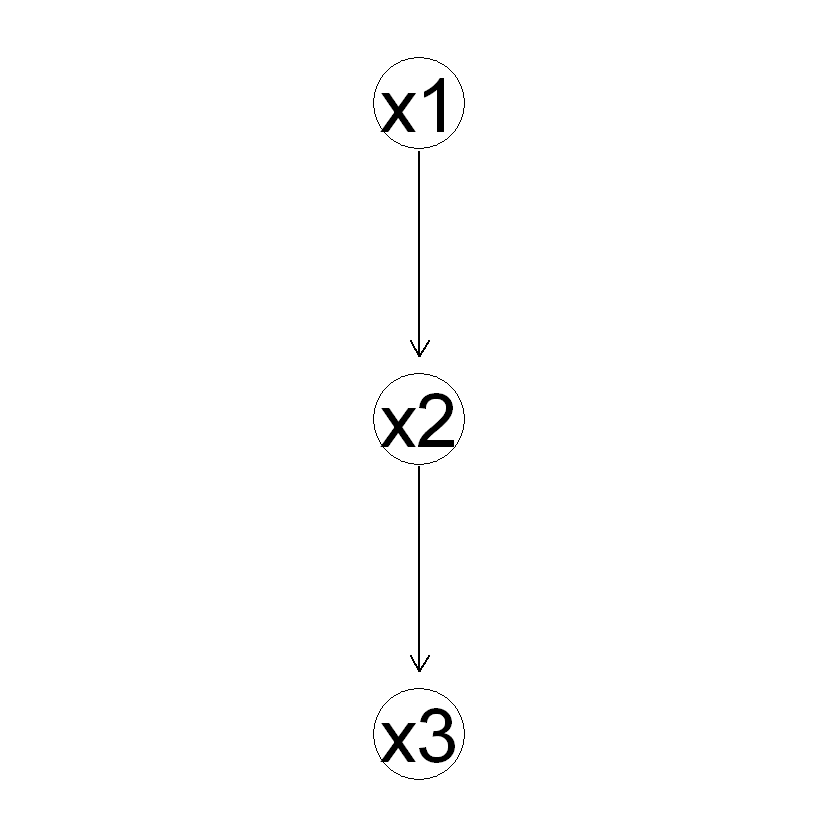

In [55]:
plot(net)

# K2 for binary generated data

* Simplest case. x2 and x3 depends on x1

In [58]:
n <- 10
x1 <- rbinom(n, 1, 1/2)
x2 <- rep(0,n)
x3 <- rep(0,n)

idx <- which(x1 == 1)

rand <- runif(length(idx))
x2[idx[rand >= 0.20]] <- 1

rand <- runif(length(idx))
x3[idx[rand >= 0.40]] <- 1

D <- data.frame(x1, x2, x3)
n <- ncol(D)
u <- c(0,1,2)
order <- names(D)

* Speed of computation using the implemented algorithm

In [60]:
start.time <- Sys.time()
K2(n, u, order, D, l= FALSE)
end.time <- Sys.time()
cat("Without log:",end.time - start.time,"sec \n")
cat("\n")
start.time <- Sys.time()
K2(n, u, order, D, l= TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Without log: 0.009063005 sec 

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
With log: 0.007997036 sec 


In [61]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',3),
                    variables = c("x1", "x2", "x3"),
                    starts.from = 0,
                    node.sizes = c(2,2,2))

layers <- c(1,2,3)
u <- c(1,2,3)

* Speed of computation using bnlearn

In [62]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.01852489 sec

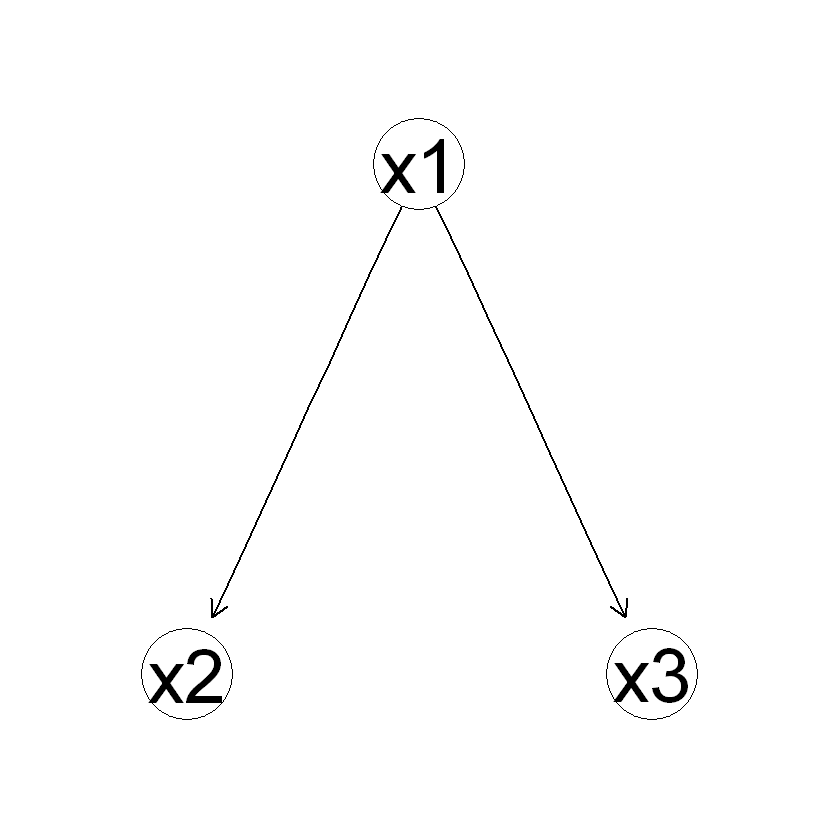

In [63]:
plot(net)

* x2 depends on x1 and x3 depends on x2

In [64]:
n <- 100
size <- 2
prob <- 1/3

x1 <- rbinom(n, size, prob)

idx <- which(x1 == 1)
x2 <- rep(0,n)
rand <- runif(length(idx))
x2[idx[rand >= 0.70]] <- 2

idx2 <- which(x2 == 2)
x3 <- rep(0,n)
rand <- runif(length(idx2))
x3[idx2[rand <= 0.20]] <- 1

D <- data.frame(x1, x2, x3)
n <- ncol(D)
u <- c(0,1,1)
order <- names(D)

* Speed of computation using the implemented algorithm

In [66]:
start.time <- Sys.time()
K2(n, u, order, D, l= FALSE)
end.time <- Sys.time()
cat("Without log:",end.time - start.time,"sec \n")
cat("\n")
start.time <- Sys.time()
K2(n, u, order, D, l= TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x2 
Without log: 0.008967161 sec 

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x2 
With log: 0.01602507 sec 


In [68]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',3),
                    variables = c("x1", "x2", "x3"),
                    starts.from = 0,
                    node.sizes = c(3,3,2))

layers <- c(1,2,3)
u <- n - 1

* Speed of computation using bnlearn

In [69]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")


bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.01596498 sec

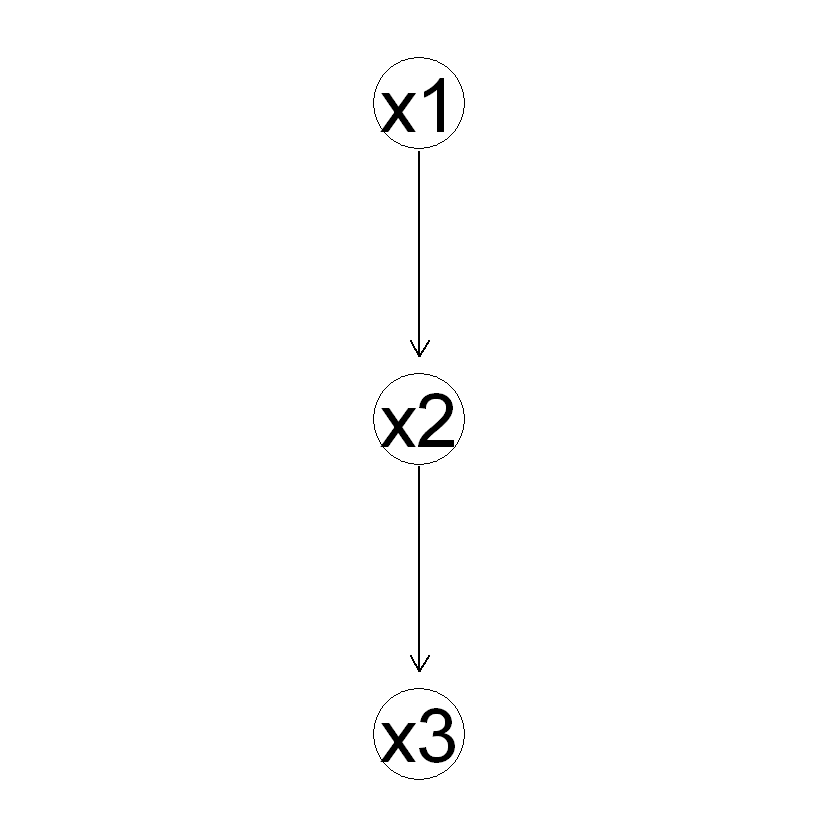

In [70]:
plot(net)

* Multiple nodes and values

In [72]:
n <- 50

x1 <- rbinom(n, 1, prob = 1/5)
x2 <- sample(0:3, n, replace = T)
x3 <- rep(0,n)
x4 <- rep(0,n)

idx2 <- which(x1 == 1)
rand <- runif(length(idx2))
x3[idx2[rand >= 0.20]] <- 1

idx2 <- which(x2 == 3)
rand <- runif(length(idx2))
x3[idx2[rand >= 0.10]] <- 2

idx3 <- which(x3 == 1)
rand <- runif(length(idx3))
x4[idx3[rand >= 0.30]] <- 1

idx3 <- which(x2 == 1)
rand <- runif(length(idx3))
x4[idx3[rand >= 0.20]] <- 2

D <- data.frame(x1, x2, x3, x4)
n <- ncol(D)
u <- c(0,1,2,3)
order <- names(D)

* Speed of computation using the implemented algorithm

In [73]:
start.time <- Sys.time()
K2(n, u, order, D, l= FALSE)
end.time <- Sys.time()
cat("Without log:",end.time - start.time,"sec \n")
cat("\n")
start.time <- Sys.time()
K2(n, u, order, D, l= TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  x1  Parents:  
Node:  x2  Parents:  
Node:  x3  Parents:  x2 x1 
Node:  x4  Parents:  x2 
Without log: 0.05040789 sec 

Node:  x1  Parents:  
Node:  x2  Parents:  
Node:  x3  Parents:  x2 x1 
Node:  x4  Parents:  
With log: 0.02997518 sec 


In [74]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',4),
                    variables = c("x1", "x2", "x3", 'x4'),
                    starts.from = 0,
                    node.sizes = c(2,4,3,3))

layers <- c(1,2,3,4)
u <- c(1,2,3,4)

* Speed of computation using bnlearn

In [75]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")


bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.0169239 sec

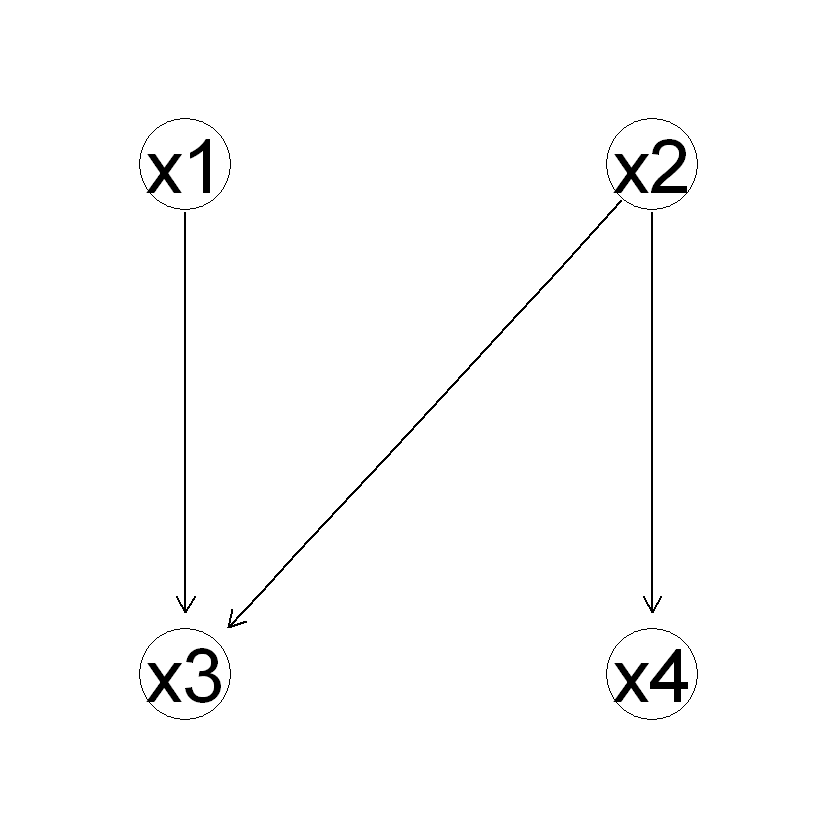

In [76]:
plot(net)

# Asia dataset

In [79]:
data <- data.frame(raw.data(asia()))
names(data) <- c('Asia', 'Tubercolosys', 'Smoke', 'LungCancer' ,'Bronchitis', 'Either' ,'X-ray', 'Dyspnea')
n <- ncol(data)
u <- c(0,1,0, 1,  1, 2, 1, 2)
order <- names(data)

* Speed of computation using the implemented algorithm 

In [90]:
start.time <- Sys.time()
K2(n, u, order, data, l= TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  Asia  Parents:  
Node:  Tubercolosys  Parents:  Asia 
Node:  Smoke  Parents:  
Node:  LungCancer  Parents:  
Node:  Bronchitis  Parents:  LungCancer 
Node:  Either  Parents:  Tubercolosys Bronchitis 
Node:  X-ray  Parents:  Either 
Node:  Dyspnea  Parents:  Smoke Either 
With log: 3.330153 sec 


In [92]:
dataset <- BNDataset(data = data,
                    discreteness = rep('d',8),
                    variables = c('Asia', 'Tubercolosys', 'Smoke', 'LungCancer' ,'Bronchitis', 'Either' ,'X-ray', 'Dyspnea'),
                    starts.from = 1,
                    node.sizes = c(2,2,2,2,2,2,2,2))

layers <- c(1,2,1, 2, 3, 3, 4, 4)
#u <- c(1,2,1, 2,  2, 3, 2, 3)
u <- n - 1 

* Speed of computation using bnlearn

In [96]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, max.parents = u, layering = layers)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.04786706 sec 


In [ ]:
plot(net)

* Speed of computation using bnlearn for the basic the "sm" (Silander-Myllym¨aki) model 

In [97]:
start.time <- Sys.time()
net2 <- learn.network(algo = "sm", x = dataset)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")



bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.07681894 sec 


In [ ]:
plot(net)

# Learning test

* Preprocessing the data

In [99]:
converter<-function(A){
    n<-length(A)
    for (i in 1:n){
        if (A[i] == "a"){
            A[i]<-as.numeric(1)
            
        }
        else if( A[i]=="b"){
             A[i]<-as.numeric(2)
        }
        else{
            A[i]<-as.numeric(3)
        }
    }
    return(as.numeric(A))
}
learning.test <- data.frame(lapply(learning.test, as.character), stringsAsFactors=FALSE)
data <- data.frame(apply(learning.test, MARGIN=2, converter ))

n <- ncol(data)
u <- c(0,0,1,1,2,2)
order <- c('F', 'C','A','B','E','D')

* Speed of computation using the implemented algorithm

In [101]:
start.time <- Sys.time()
K2(n, u, order, data, l=TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  F  Parents:  
Node:  C  Parents:  
Node:  A  Parents:  
Node:  B  Parents:  A 
Node:  E  Parents:  B F 
Node:  D  Parents:  A C 
With log: 2.794676 sec 


In [102]:
dataset <- BNDataset(data = data,
                    discreteness = rep('d',6),
                    variables = c('A', 'B','C','D','E','F'),
                    starts.from = 1,
                    node.sizes = c(3,3,3,3,3,2))

layers <- c(2, 2, 1, 3, 3, 1)
u <- c(2, 2, 1, 3, 3, 1)
#u <- n - 1 

* Speed of computation using bnlearn

In [105]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, max.parents = u, layering = layers)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")

bnstruct :: learning the structure using SM ...

Warning message in max.fanin.layers > max.fanin:
"longer object length is not a multiple of shorter object length"
Warning message in max.fanin.layers[max.fanin.layers > max.fanin] <- max.fanin:
"il numero di elementi da sostituire non è un multiplo della lunghezza di sostituzione"
bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.02487016 sec 


In [ ]:
plot(net)


* Speed of computation using bnlearn for the basic the "sm" (Silander-Myllym¨aki) model

In [106]:
start.time <- Sys.time()
net2 <- learn.network(algo = "sm", x = dataset)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.02494097 sec 


In [ ]:
plot(net2)